In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
import pickle
from sklearn.model_selection import GridSearchCV
import  seaborn as sns

In [ ]:
'''import zipfile

zip_file_path = '/content/sd.zip'
extract_to_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset extracted to: {extract_to_path}")'''

'import zipfile\n\nzip_file_path = \'/content/sd.zip\'\nextract_to_path = \'/content\'\n\nwith zipfile.ZipFile(zip_file_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_to_path)\n\nprint(f"Dataset extracted to: {extract_to_path}")'

In [ ]:
Categories = ['VI-shingles', 'VI-chickenpox', 'BA- cellulitis', 'FU-athlete-foot',
              'BA-impetigo', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans','Healthy']

In [ ]:
test_dir = r'/content/skin-disease-datasaet/test_set'
train_dir = r'/content/skin-disease-datasaet/train_set'

In [ ]:
img_size = (224, 224)
def preprocess_image(image):
    if image is None:
        raise ValueError("Image is None")

    # Ensure image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Resize
    image = cv2.resize(image, img_size)

    # Contrast Enhancement (CLAHE)
    try:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge([l, a, b])
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    except Exception as e:
        print(f"Warning: CLAHE enhancement failed, using original image. Error: {str(e)}")

    # Convert to float32 and normalize to [0, 1]
    image = image.astype(np.float32)

    # Apply ResNet50 preprocessing
    image = resnet_preprocess(image)
    return image


In [ ]:
def create_data(directory):
    data = []
    labels = []

    for idx, category in enumerate(Categories):
        path = os.path.join(directory, category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue

                processed_img = preprocess_image(img)
                data.append(processed_img)
                labels.append(idx)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

    return np.array(data), np.array(labels)

In [ ]:
def augment_data(images, labels, augmentation_per_image=2):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='reflect',
        rescale=1./255
    )

    augmented_images = []
    augmented_labels = []

    # Add original images and labels
    augmented_images.extend(images)
    augmented_labels.extend(labels)

    print(f"\nAugmenting data... Original size: {len(images)}")

    # Generate augmented images
    for i in range(len(images)):
        img = images[i]
        label = labels[i]
        img_reshaped = np.expand_dims(img, 0)

        # Generate n augmented versions of each image
        for _ in range(augmentation_per_image):
            augmented = next(datagen.flow(img_reshaped, batch_size=1))[0]
            augmented_images.append(augmented)
            augmented_labels.append(label)

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1} images...")

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    print(f"Augmentation complete. New size: {len(augmented_images)}")

    return augmented_images, augmented_labels


In [ ]:
def plot_sample_images(data, labels, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(min(num_samples, len(data))):
        plt.subplot(1, num_samples, i+1)
        img = data[i]

        # Normalize the image to [0, 1]
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 and rescale to [0, 255]
        img = (img * 255).astype(np.uint8)

        # Convert from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.imshow(img)
        plt.title(f"{Categories[labels[i]].split('-')[0]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_class_distribution(directory):
    class_counts = []
    for category in Categories:
        path = os.path.join(directory, category)
        count = len(os.listdir(path))
        class_counts.append(count)

    plt.figure(figsize=(10, 6))
    plt.pie(class_counts, labels=[cat.split('-')[0] for cat in Categories], autopct='%1.1f%%')
    plt.title('Distribution of Images Across Classes')
    plt.axis('equal')
    plt.show()


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[cat.split('-')[0] for cat in Categories],
                yticklabels=[cat.split('-')[0] for cat in Categories])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


Loading training data...
Original training data shape: (1021, 224, 224, 3)

Loading test data...
Test data shape: (262, 224, 224, 3)

Performing data augmentation...

Augmenting data... Original size: 1021
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Augmentation complete. New size: 3063
Augmented training data shape: (3063, 224, 224, 3)

Extracting features using ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step

Training SVM...
RAPIDS not available. Falling back to scikit-learn's SVM.

Evaluating the SVM model...

Classification Report:
                            precision    recall  f1-score   support

               VI-shingles       0.97      0.94      0.95        33
             VI-chickenpox  

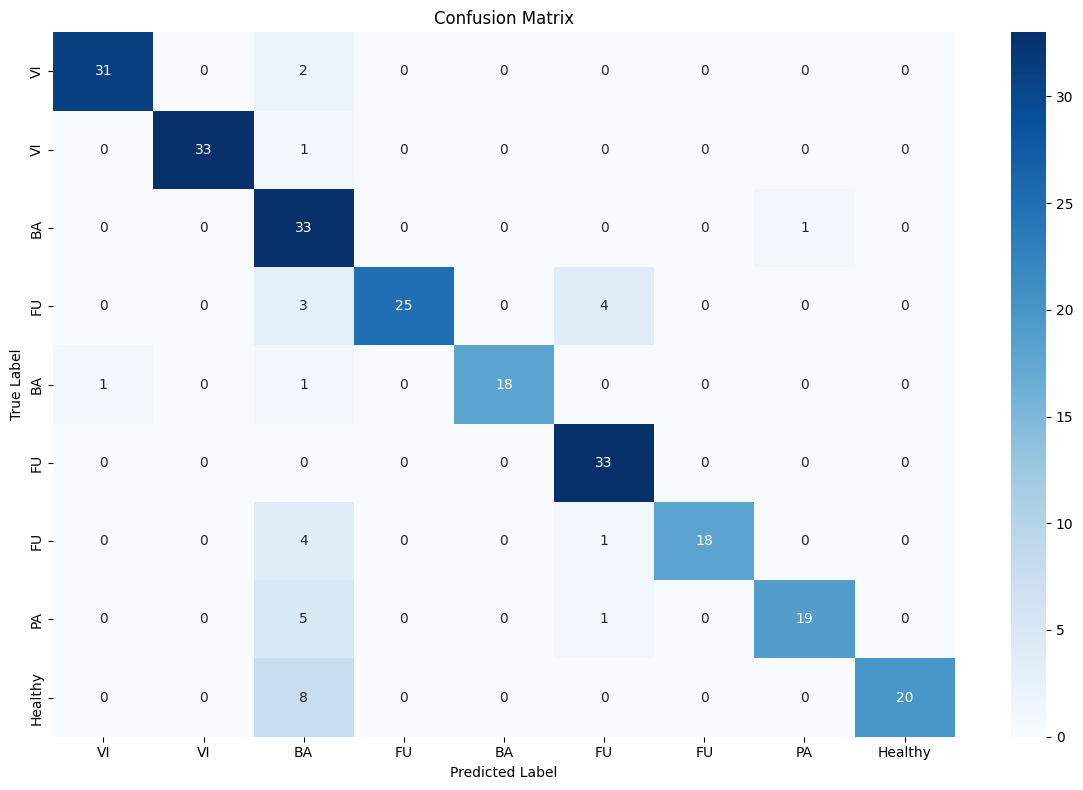


Saving the trained SVM model to 'svm_model_optimized.pkl'...


SVM model saved successfully.

Saving the ResNet50 base model to 'resnet50_base_model.h5'...
ResNet50 base model saved successfully.


In [ ]:
if __name__ == "__main__":
    # Load and preprocess data
    print("Loading training data...")
    train_data, train_labels = create_data(train_dir)
    print(f"Original training data shape: {train_data.shape}")

    print("\nLoading test data...")
    test_data, test_labels = create_data(test_dir)
    print(f"Test data shape: {test_data.shape}")

    # Perform data augmentation
    print("\nPerforming data augmentation...")
    train_data_augmented, train_labels_augmented = augment_data(train_data, train_labels)
    print(f"Augmented training data shape: {train_data_augmented.shape}")

    # Feature Extraction using ResNet50
    print("\nExtracting features using ResNet50...")
    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_shape=(img_size[0], img_size[1], 3))

    train_features = base_model.predict(train_data_augmented, batch_size=32, verbose=1)
    test_features = base_model.predict(test_data, batch_size=32, verbose=1)

    # Flatten features
    train_features_flat = train_features.reshape(train_features.shape[0], -1)
    test_features_flat = test_features.reshape(test_features.shape[0], -1)

    # Train SVM with GPU acceleration (if RAPIDS is available)
    print("\nTraining SVM...")
    try:
        from cuml.svm import SVC
        print("Using RAPIDS cuML for GPU-accelerated SVM training.")
        svm_model = SVC(probability=True)
    except ImportError:
        from sklearn.svm import SVC
        print("RAPIDS not available. Falling back to scikit-learn's SVM.")
        svm_model = SVC(probability=True)

    svm_model.fit(train_features_flat, train_labels_augmented)

    # Evaluate the SVM model
    print("\nEvaluating the SVM model...")
    predictions = svm_model.predict(test_features_flat)
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions, target_names=Categories))

    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(test_labels, predictions)

    # Save the trained SVM model
    print("\nSaving the trained SVM model to 'svm_model_optimized.pkl'...")
    with open("svm_model_optimized.pkl", "wb") as model_file:
        pickle.dump(svm_model, model_file)
    print("SVM model saved successfully.")

    # Save the ResNet50 base model
    print("\nSaving the ResNet50 base model to 'resnet50_base_model.h5'...")
    base_model.save("resnet50_base_model.h5")
    print("ResNet50 base model saved successfully.")
